In [69]:
import pandas as pd
import json
import string
import nltk
from wordcloud import WordCloud
import re
from statistics import mean 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def read_json_as_list_of_reviews(file_location:str)-> list:
    with open(file_location, "r") as fr:
        return json.loads(fr.read())

In [4]:
reviews = read_json_as_list_of_reviews("../data/reviews_received/samsung-galaxy-a70-black-128-gb.json")

In [5]:
print(len(reviews))

464


In [6]:
print(reviews[0])

{'rating': '5', 'title': 'Super!', 'review_text': 'fabulous phone loved it....😍😘😘READ MORE', 'reviewer': 'Rahul Pal', 'review_date': 'Rahul Pal', 'review_upvotes': '965', 'review_downvotes': '201'}


In [7]:
reviews_df = pd.DataFrame(reviews)
reviews_df.head()

,rating,review_date,review_downvotes,review_text,review_upvotes,reviewer,title
0,5,Rahul Pal,201,fabulous phone loved it....😍😘😘READ MORE,965,Rahul Pal,Super!
1,5,KiranKumar Gajjala,165,Simply love it.. after 2 days of usage.Battery...,799,KiranKumar Gajjala,Samsung Nailed it. Amazing Phone
2,4,Sethukrishnan P,157,Awesome midrange smart phone with reasonably g...,760,Sethukrishnan P,Good choice
3,5,manthan pandey,14,awesome phoneREAD MORE,97,manthan pandey,Highly recommended
4,4,Flipkart Customer,22,fingerprint sensor not working properly.remain...,131,Flipkart Customer,Good choice


## Datatype conversion

In [36]:
reviews_df["rating"] = reviews_df["rating"].astype(int)
reviews_df["review_downvotes"] = reviews_df["review_downvotes"].astype(int)
reviews_df["review_upvotes"] = reviews_df["review_upvotes"].astype(int)
reviews_df["review_text"] = reviews_df["review_text"].astype(str)

In [57]:
def get_upvote_to_downvote_ratio(row):
    if row["review_downvotes"] != 0:
        return row["review_upvotes"]/row["review_downvotes"]
    return 0

def get_normalized_rating(row):
    replace_values = {
        0: -2,
        1: -2,
        2: -1,
        3: 0,
        4: 1,
        5: 2
    }
    return replace_values[row["rating"]]

reviews_df["upvote_ratio"] = reviews_df.apply(get_upvote_to_downvote_ratio, axis=1)
reviews_df["normalized_rating"] = reviews_df.apply(get_normalized_rating, axis=1)

In [58]:
reviews_df.head(5)

,rating,review_date,review_downvotes,review_text,review_upvotes,reviewer,title,upvote_ratio,processed_review_text,normalized_rating
0,5,Rahul Pal,201,fabulous phone loved it....😍😘😘READ MORE,965,Rahul Pal,Super!,4.800995,fabulous phone loved 😍😘😘,2
1,5,KiranKumar Gajjala,165,Simply love it.. after 2 days of usage.Battery...,799,KiranKumar Gajjala,Samsung Nailed it. Amazing Phone,4.842424,simply love 2 days usage battery charging time...,2
2,4,Sethukrishnan P,157,Awesome midrange smart phone with reasonably g...,760,Sethukrishnan P,Good choice,4.840764,awesome midrange smart phone reasonably good c...,1
3,5,manthan pandey,14,awesome phoneREAD MORE,97,manthan pandey,Highly recommended,6.928571,awesome phone,2
4,4,Flipkart Customer,22,fingerprint sensor not working properly.remain...,131,Flipkart Customer,Good choice,5.954545,fingerprint sensor working properly remaining ...,1


In [59]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [60]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english'))

def process_review_text(review_obj):
    review_text = review_obj[0]
    
    # replace the read more text
    review_text = review_text.replace("READ MORE", "")
    
    # convert to lower case
    review_text = review_text.lower()
    
    # pattern, replacement, string to update
    review_text = re.sub("[.]+", " ", review_text)
    
    word_tokens = word_tokenize(review_text)
    #print(word_tokens)
    
    stripped_word_tokens = [w.strip() for w in word_tokens]
    word_tokens_no_punctuation = [w for w in stripped_word_tokens if w not in string.punctuation]
    filtered_review = [w for w in word_tokens_no_punctuation if w not in stop_words]
    #print(filtered_review)
    
    # remove all empty words
    filtered_review = [w for w in filtered_review if w]
    
    processed_review_text = " ".join(filtered_review)
    
    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    # review_text.translate(None, string.punctuation)
    # review_text = review_text.translate(review_text.maketrans('', '', string.punctuation))
    return processed_review_text

In [61]:
r = process_review_text(["fabulous phone loved it, cat,dog is pig READ MORE"])
print(r)

fabulous phone loved cat dog pig


In [62]:
reviews_df["processed_review_text"] = reviews_df[["review_text"]].apply(process_review_text, axis=1)
reviews_df["processed_review_text"].head(10)

0                             fabulous phone loved 😍😘😘
1    simply love 2 days usage battery charging time...
2    awesome midrange smart phone reasonably good c...
3                                        awesome phone
4    fingerprint sensor working properly remaining ...
5    phone camera battery display awesome fingerpri...
6                                 looking hot loved go
7    amazing mid range phone 25w super fast charge ...
8    words say camera battery perfomance insane spe...
9                                              awesome
Name: processed_review_text, dtype: object

In [63]:
all_reviews_concat = " ".join(reviews_df["processed_review_text"].values)
all_reviews_concat[:100]

'fabulous phone loved 😍😘😘 simply love 2 days usage battery charging time 1hr 50 mins 0 100 80 100 tak'

In [64]:
def generate_word_cloud_for_reviews(df):
    reviews_concat = " ".join(df["processed_review_text"].values)
    wordcloud = WordCloud().generate(reviews_concat)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    

In [65]:
positive_reviews_df = reviews_df[(reviews_df["rating"] >= 3) & (reviews_df["rating"] <= 5)]
negative_reviews_df = reviews_df[(reviews_df["rating"] >= 0) & (reviews_df["rating"] <= 3)]

In [66]:
total_positive_reviews = positive_reviews_df.shape[0]
total_negative_reviews = negative_reviews_df.shape[0]
total_reviews = reviews_df.shape[0]
print("Positive reviews %: {0} (Ratings from 3-5)".format((total_positive_reviews/total_reviews) * 100))
print("Negative reviews %: {0} (Ratings from 1-3)".format((total_negative_reviews/total_reviews) * 100))

Positive reviews %: 85.77586206896551 (Ratings from 3-5)
Negative reviews %: 23.70689655172414 (Ratings from 1-3)


In [67]:
def get_average_upvote_ratio(df):
    df["norma_rtg_x_upv_rto"] = df["normalized_rating"] * df["upvote_ratio"]
    return abs(mean(df["norma_rtg_x_upv_rto"].values))

In [70]:
print("Average upvote ratio for positive reviews {0}".format(get_average_upvote_ratio(positive_reviews_df)))
print("Average upvote ratio for negative reviews {0}".format(get_average_upvote_ratio(negative_reviews_df)))

Average upvote ratio for positive reviews 1.0875322486230412
Average upvote ratio for negative reviews 0.8116606378371084


/home/anurag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


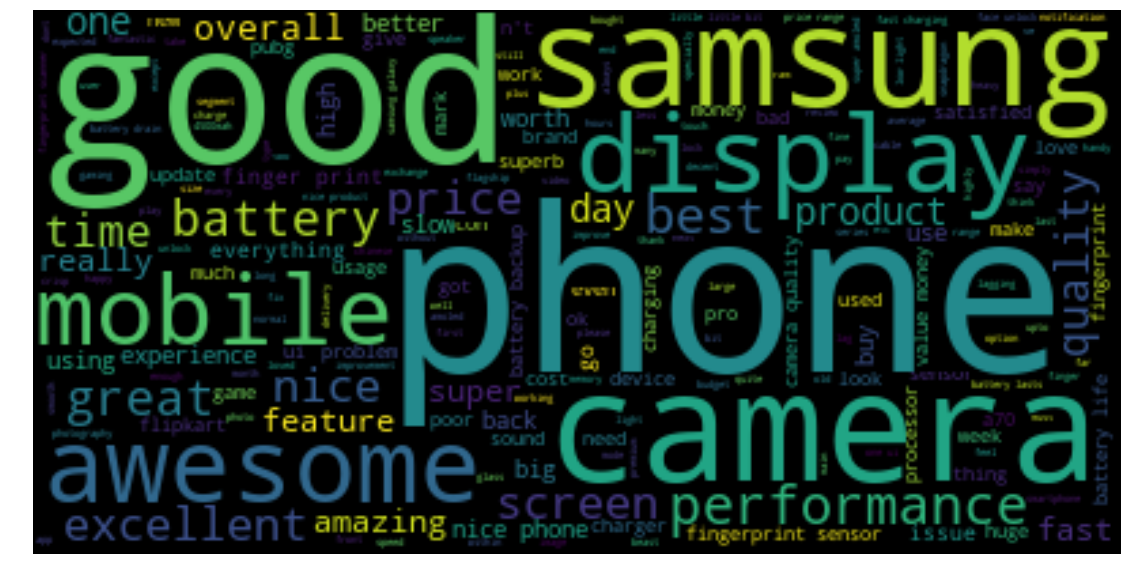

In [41]:
generate_word_cloud_for_reviews(positive_reviews_df)

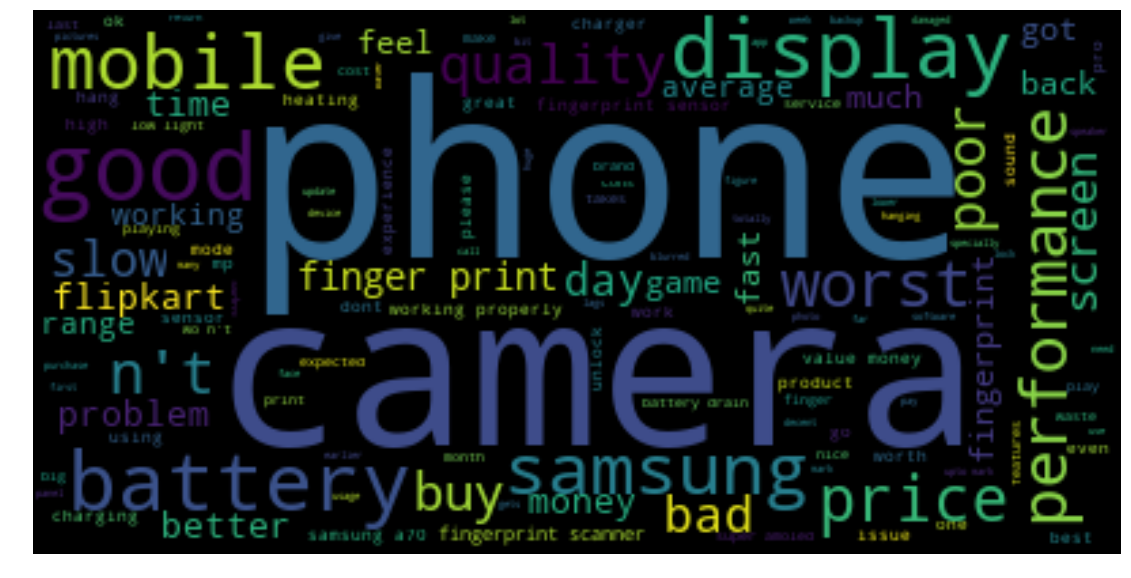

In [42]:
generate_word_cloud_for_reviews(negative_reviews_df)